# Libs

In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Masking
import matplotlib
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from WickelfeaturesProject.keras_metrics import KerasMetrics
from keras.optimizers import adam
import keras.backend as K
from sklearn.metrics import f1_score
from scipy.spatial import distance
import pickle
opt = adam()

Using TensorFlow backend.


# Data

In [4]:
corpus = pd.read_csv("WickelfeaturesProject/Corpus new coding/corpus_complete.csv", names=['verb0', 'inf_verb', 'conj_verb0', 'conj_verb'])

In [5]:
corpus.drop(['verb0','conj_verb0'], axis=1,inplace=True)

In [6]:
corpus['conj_verb'] = corpus.conj_verb.apply(lambda x: x.strip('#'))

In [7]:
corpus['inf_verb'] = corpus.inf_verb.apply(lambda x: x.strip('#'))

In [8]:
corpus.head()

,inf_verb,conj_verb
0,Ansia,Anseiu
1,odia,odeiu
2,pleitea,pleiteiu
3,ins3ndia,ins3ndeiu
4,sortea,sorteiu


In [9]:
corpus.to_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used', index=False)

In [10]:
corpus['conj_verb'] = corpus.conj_verb.apply(lambda x: '#'+x+ '$')

In [11]:
corpus.head()

,inf_verb,conj_verb
0,Ansia,#Anseiu$
1,odia,#odeiu$
2,pleitea,#pleiteiu$
3,ins3ndia,#ins3ndeiu$
4,sortea,#sorteiu$


In [12]:
corpus.to_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used', index=False)

In [2]:
corpus = pd.read_csv('WickelfeaturesProject/Corpus new coding/actual_corpus_used')

In [3]:
corpus.head()

,inf_verb,conj_verb
0,Ansia,#Anseiu$
1,odia,#odeiu$
2,pleitea,#pleiteiu$
3,ins3ndia,#ins3ndeiu$
4,sortea,#sorteiu$


# Features

In [4]:
features = ['oclusiva', 'nasal', 'tepe', 'fricativa', 'l-aprox', 'bilabial', 'labiodental',
           'alveolar', 'p-alveolar', 'palatal', 'velar', 'glotal', 'vozeada', 'fechada',
           'm-fechada', 'm-aberta', 'aberta', 'anterior', 'posterior', 'beg', 'end']

In [5]:
#http://www.ipachart.com/
phones = {
"p" : ['bilabial', 'oclusiva'],
"b" : ['bilabial', 'oclusiva', 'vozeada'],
"f" : ['labiodental', 'fricativa'],
"v" : ['labiodental', 'fricativa', 'vozeada'],
"t" : ['alveolar', 'oclusiva'],
"d" : ['alveolar', 'oclusiva', 'vozeada'],
"m" : ['bilabial', 'nasal'],
"n" : ['alveolar', 'nasal'],
"k" : ['velar', 'oclusiva'],
"g" : ['velar', 'oclusiva', 'vozeada'],
"N" : ['nasal', 'palatal'],
"r" : ['alveolar', 'tepe'],
"s" : ['alveolar', 'fricativa'],
"z" : ['alveolar', 'fricativa', 'vozeada'],
"j" : ['p-alveolar', 'fricativa', 'vozeada'],
"l" : ['l-aprox', 'p-alveolar'],
"L" : ['l-aprox', 'palatal'],
"h" : ['glotal', 'fricativa'],
"x" : ['fricativa', 'p-alveolar'],
"i" : ['anterior', 'fechada'],
"e" : ['m-fechada', 'anterior'],
"E" : ['m-aberta', 'anterior'],
"a" : ['anterior', 'aberta'],
"u" : ['posterior', 'fechada'],
"o" : ['m-fechada', 'posterior'],
"O" : ['m-aberta', 'posterior'],
"A" : ['anterior', 'aberta', 'nasal'],
"3" : ['m-fechada', 'anterior', 'nasal'],
"PAD": [''],
"#" : ['beg'],
"$" : ["end"]}

In [6]:
with open('WickelfeaturesProject/Files/phones.pickle', 'wb') as file:
    pickle.dump(phones, file, protocol=pickle.HIGHEST_PROTOCOL)

# Functions

In [7]:
def code(phone): 
    array = []
    for item in features:
        if item in phones[phone]:
            array.append(1)
        else:
            array.append(0)
    return np.array(array)

code('h')

code('#')

In [ ]:
def preprocessing(df):
    
    df.drop(['verb0','conj_verb0'], axis=1,inplace=True)
    df['inf_verb'] = df.inf_verb.str.strip('#')
    df['conj_verb'] = df.conj_verb.apply(lambda x: x[:-1] + '$')
    return df

In [10]:
def code_verb(verb):
    coded = list()
    for item in verb:
        coded.append(code(item))
    return np.array(coded)

code_verb('falu')

def verify(verb):
    for phone in verb:
        if phone not in phones.keys():
            print(phone, verb)
        else:
            pass

In [94]:
def preprocessing(df):
    
    df.drop(['verb0','conj_verb0'], axis=1,inplace=True)
    df['inf_verb'] = df.inf_verb.str.strip('#')
    df['conj_verb'] = df.conj_verb.apply(lambda x: x[:-1] + '$')
    coded_in = corpus.inf_verb.apply(code_verb)
    coded_out = corpus.conj_verb.apply(code_verb)
    coded_out_target = coded_out.apply(lambda x: np.vstack((x[1:],np.zeros(21))))
    padded_in = pad_sequences(coded_in, value=np.zeros(21))
    padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")
    padded_out_target = pad_sequences(coded_out_target, value=np.zeros(21),padding="post")
        
    return df, coded_in, coded_out, padded_in, padded_out

# Maximum Length of input and output

In [25]:
corpus.inf_verb.str.len().max()

11

In [12]:
max_decoder_seq_length = corpus.conj_verb.str.len().max()

In [27]:
max_decoder_seq_length

13

# Padding

In [13]:
coded_in = corpus.inf_verb.apply(code_verb)

In [14]:
input_texts = corpus.inf_verb[-30:]

In [30]:
input_texts

393         sabe
394      ekivale
395        prove
396        traze
397         pode
398        desda
399         idea
400       estrea
401           da
402     sobresta
403         esta
404         kabe
405         ouvi
406    entreouvi
407       heouvi
408         pari
409        perde
410        testa
411     obiserva
412      eskolie
413     konversa
414         fexa
415        gosta
416        volta
417      espresa
418        pasea
419       akorda
420        korta
421       aumosa
422       injeri
Name: inf_verb, dtype: object

In [17]:
coded_out = corpus.conj_verb.apply(code_verb)

coded_in[0]

In [20]:
padded_in = pad_sequences(coded_in, value=np.zeros(21))
padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")

In [21]:
padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")
padded_out.shape

(423, 13, 21)

about pre padding: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results

# Test Split

In [22]:
x_test = padded_in[-30:]
y_test = padded_out[-30:]

padded_in = padded_in[:-30]
padded_out = padded_out[:-30]

# Preprocessing

In [99]:
def preprocessing(df):
    
    #df.drop(['verb0','conj_verb0'], axis=1,inplace=True)
    df['inf_verb'] = df.inf_verb.str.strip('#')
    df['conj_verb'] = df.conj_verb.apply(lambda x: x[:-1] + '$')
    coded_in = corpus.inf_verb.apply(code_verb)
    coded_out = corpus.conj_verb.apply(code_verb)
    coded_out_target = coded_out.apply(lambda x: np.vstack((x[1:],np.zeros(21))))
    padded_in = pad_sequences(coded_in, value=np.zeros(21))
    padded_out = pad_sequences(coded_out, value=np.zeros(21),padding="post")
    padded_out_target = pad_sequences(coded_out_target, value=np.zeros(21),padding="post")
        
    return df, coded_in, coded_out, padded_in, padded_out

In [74]:
frame = pd.read_csv("WickelfeaturesProject/Corpus_new_coding/403verbs.csv")


In [70]:
corpus

,inf_verb,conj_verb
0,Ansia,#Anseiu$
1,odia,#odeiu$
2,pleitea,#pleiteiu$
3,ins3ndia,#ins3ndeiu$
4,sortea,#sorteiu$
5,hemedia,#hemedeiu$
6,intermedia,#intermedeiu$
7,media,#medeiu$
8,oLa,#OLu$
9,koloka,#kolOku$


# The Network

In [37]:
latent_dim = 256
num_encoder_tokens = 21

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens)) #19
#encoder_inputs = Masking()(encoder_inputs) # Assuming PAD is zeros
encoder = LSTM(latent_dim, return_state=True)
# Now the LSTM will ignore the PADs when encoding
# by skipping those timesteps that are masked
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
num_decoder_tokens = 21
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [38]:
num_encoder_tokens

21

In [25]:
coded_out_target = coded_out.apply(lambda x: np.vstack((x[1:],np.zeros(21))))

In [26]:
padded_out.shape

(393, 13, 21)

In [27]:
padded_out_target = pad_sequences(coded_out_target, value=np.zeros(21),padding="post")

In [44]:
#because of test split
padded_out_target = padded_out_target[:-30]

In [48]:
%%time
# Run training
keras_metrics = KerasMetrics()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[ keras_metrics.fbeta_score,
               keras_metrics.recall,
               keras_metrics.precision]) #, mean_pred],)
model.save_weights('WickelfeaturesProject/new_model_1.h5')
history = model.fit([padded_in, padded_out],
                    padded_out_target,
                    batch_size=128,
                    epochs=300,
                    validation_split=0.2,verbose=False)

CPU times: user 11min 33s, sys: 1min 23s, total: 12min 57s
Wall time: 3min 45s


In [49]:
history.history.keys()

dict_keys(['val_loss', 'val_fbeta_score', 'val_recall', 'val_precision', 'loss', 'fbeta_score', 'recall', 'precision'])

## F1 score Plot

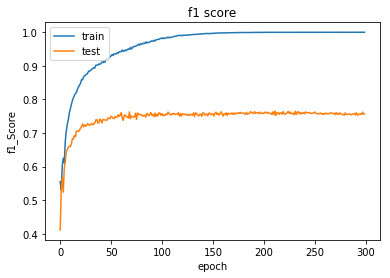

In [50]:
# summarize history for accuracy
plt.plot(history.history['fbeta_score'])
plt.plot(pd.Series(history.history['val_fbeta_score']))
plt.title('f1 score')
plt.ylabel('f1_Score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [51]:
history.history['val_fbeta_score'][-1]

0.7563260793685913

## Recall Score Plot

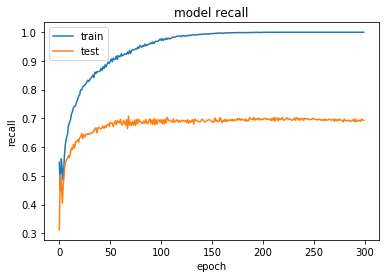

In [52]:
# summarize history for accuracy
score = 'recall'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [53]:
history.history['val_recall'][-1]

0.6927038431167603

## Precision Score Plot

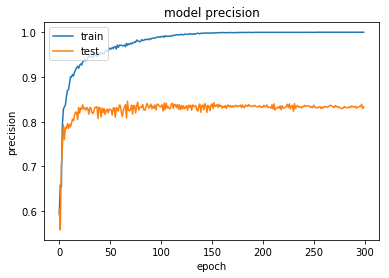

In [54]:
score = 'precision'
plt.plot(history.history[score])
plt.plot(pd.Series(history.history['val_{}'.format(score)]))
plt.title('model {}'.format(score))
plt.ylabel(score)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [55]:
history.history['val_precision'][-1]

0.8328173160552979

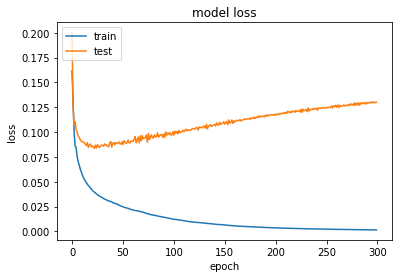

In [56]:
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Predict

## Euclidean Distance

from scipy.spatial import distance
a = np.array([0,0,1])
b = np.array([0, 0, 1])
dst = distance.euclidean(a, b)
dst

In [57]:
phone_arrays = {}
for phone in phones:
    phone_arrays[phone] = code(phone)
phone_arrays

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
import pickle
phone_arrays = {}
for phone in phones:
    phone_arrays[phone] = code(phone)
phone_arrays
with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'wb') as file:
    pickle.dump(phone_arrays, file, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'rb') as file:
    phone_arrays = pickle.load(file)

In [60]:
phone_arrays

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [61]:
def find_closest_array(predicted):
    """
    Find closest array.
    
    Parameters:
    ----------   
    predicted : type array
    
    Returns:
    -------
    candidate : type string
    """
    min_dst = 10000
    candidate = ''
    import pickle 
    with open('WickelfeaturesProject/Files/phone_arrays.pickle', 'rb') as file:
        phone_arrays = pickle.load(file)
    del phone_arrays['PAD']
    for phone in phone_arrays:
        dst = distance.euclidean(predicted, phone_arrays[phone])
        # finds the minimum distance first
        if dst < min_dst:
            min_dst = dst
            candidate = phone
    return candidate       
#     for phone in phone_arrays:
#             dst = distance.euclidean(predicted, phone_arrays[phone])
#             if dst == min_dst:
#                 # appends all possible candidates to a list
#                 candidates.append(phone)
#     if len(candidates) > 1:
#         return  '+'.join(candidates) 
#     else:
#         return ''.join(candidates)

In [62]:
# test if it returns 3
find_closest_array([0,1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,0,0])

'3'

In [63]:
# test if it returns a list
find_closest_array([.678, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,0,0])

'p'

 ---

## Inference mode

In [64]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [65]:
lookup = {}
for phone in phones:
    lookup[phone] = code(phone)    

In [66]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'wb') as file:
    pickle.dump(lookup, file, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
def reverse_phone(array):
    for item in lookup:
        if np.all(array == lookup[item]):
            return item

In [68]:
coded_in[0][0]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [69]:
reverse_phone(coded_in[0][0])

'A'

In [70]:
reverse_phone([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'PAD'

In [71]:
lookup

{'p': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'b': array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'f': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'v': array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'd': array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'm': array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'n': array([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'k': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'g': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 'N': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'r': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 's': array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [72]:
del lookup['PAD']

In [73]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'wb') as file:
    pickle.dump(lookup, file, protocol=pickle.HIGHEST_PROTOCOL)

In [74]:
lookup['PAD'] = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [75]:
with open('WickelfeaturesProject/Files/lookup.pickle', 'rb') as file:
    lookup = pickle.load(file)
    
def decode_sequence(input_seq, renormalize=False):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 21)) # max decoder len = 13, 21 features
    max_decoder_seq_length = 13
    
    #Populate the first character of target sequence with the start character.
    target_seq= lookup['#'].reshape(1, 1, -1)

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_verb = ''
    while not stop_condition:
        output_phones, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a phone
        if renormalize:
            sampled_phone = find_closest_array(output_phones[0, -1, :]/omega)
        else:
            sampled_phone = find_closest_array(output_phones[0, -1, :])                                               
        sampled_phone_vector = lookup[sampled_phone]
        decoded_verb += sampled_phone
        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_phone == '$' or 
           len(decoded_verb) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = sampled_phone_vector.reshape(1, 1, -1)
#         target_seq = np.zeros((1, 1, num_decoder_tokens))
#         target_seq[0, 0, sampled_phone_vector] = 1.

        # Update states
        states_value = [h, c]

    return decoded_verb[:-1]

def decode_sequences(seq, renormalize=False):
    if len(seq.shape) == 3:
        return [decode_sequence(s.reshape(1,*s.shape), renormalize=renormalize) for s in seq]
    else:
        return [decode_sequence(seq.reshape(1,*seq.shape), renormalize=renormalize)]

# Test

In [77]:
omega = 2*padded_out.mean(axis=0).mean(axis=0)

In [83]:
pd.DataFrame([decode_sequences(x_test), decode_sequences(x_test,True)], columns=input_texts.tolist(), index=['No renorm', 'Renorm']).T

,No renorm,Renorm
sabe,sabu,sabu
ekivale,egili,egeligu
prove,provu,provu
traze,trazu,trazu
pode,pOtu,bOsu
desda,desku,dezku
idea,idiu,adiu
estrea,estreiu,estreiu
da,diu,diu
sobresta,sospretu,sosprAtu


In [84]:
#pd.DataFrame(decode_sequences(padded_in[:10]), corpu9s.inf_verb.tolist()[:10])

,0
Ansia,Anseiu
odia,odeiu
pleitea,pleiteiu
ins3ndia,ins3ndeiu
sortea,sorteiu
hemedia,hemedeiu
intermedia,intermedeiu
media,medeiu
oLa,OLu
koloka,kolOku


# Learning Curve x Train Size

In [30]:
%%time
# Run training

def train(length):
    latent_dim = 256
    num_encoder_tokens = 21

    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens)) #19
    #encoder_inputs = Masking()(encoder_inputs) # Assuming PAD is zeros
    encoder = LSTM(latent_dim, return_state=True)
    # Now the LSTM will ignore the PADs when encoding
    # by skipping those timesteps that are masked
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]

    # Set up the decoder, using `encoder_states` as initial state.
    num_decoder_tokens = 21
    decoder_inputs = Input(shape=(None, num_decoder_tokens))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                             initial_state=encoder_states)
    decoder_dense = Dense(num_decoder_tokens, activation='sigmoid')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    keras_metrics = KerasMetrics()
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[ keras_metrics.fbeta_score,
                   keras_metrics.recall,
                   keras_metrics.precision]) #, mean_pred],)
    history = model.fit([padded_in[:length], padded_out[:length]],
                        padded_out_target[:length],
                        batch_size=128,
                        epochs=300,
                        validation_split=0.2,verbose=False)
    
    return history.history['val_fbeta_score'][-1], history.history['recall'][-1], history.history['precision'][-1]

lc = {}
for length in [100, 150, 250, 300, 393]:
    lc[length] = train(length)

CPU times: user 35min 18s, sys: 3min 47s, total: 39min 5s
Wall time: 11min 20s


In [31]:
lc

{100: (0.5534803867340088, 0.6876574158668518, 0.9181614518165588),
 150: (0.5637180805206299, 0.7294632792472839, 0.9192546606063843),
 250: (0.7961629629135132, 0.8921688175201417, 0.9658581089973449),
 300: (0.7927590012550354, 0.9350285490353902, 0.9777678648630778),
 393: (0.7852533459663391, 0.9763083427574983, 0.9875784125297692)}

with open('WickelfeaturesProject/Files/learning_curve.pickle', 'wb') as file:
    pickle.dump(lc, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('WickelfeaturesProject/Files/lc.pickle', 'rb') as file:
    lc = pickle.load(file)

# Error Analysis

Let's generate a test set that is fair with respesct to the representativity of multiple irregular classes.

In [100]:
frame = pd.read_csv("WickelfeaturesProject/Corpus_new_coding/403verbs.csv")

In [101]:
df, coded_in, coded_out, padded_in, padded_out = preprocessing(frame)

In [102]:
df

,inf_verb,conj_verb
0,Ansia,#Anseiu$
1,odia,#odeiu$
2,pleitea,#pleiteiu$
3,ins3ndia,#ins3ndeiu$
4,sortea,#sorteiu$
5,hemedia,#hemedeiu$
6,intermedia,#intermedeiu$
7,media,#medeiu$
8,pasea,#paseiu$
9,oLa,#OLu$


In [43]:
frame.shape

(403, 4)

In [44]:
0.8*403

322.40000000000003

In [39]:
corpus2 = pd.concat()

,verb0,inf_verb,conj_verb0,conj_verb
0,ansiar,#ansia#,anseio,#anseiu#
1,odiar,#odia#,odeio,#odeiu#
2,pleitear,#pleitea#,pleiteio,#pleiteiu#
3,incendiar,#insendia#,incenceio,#insendeiu#
4,sortear,#sortea#,sorteio,#sorteiu#
5,remediar,#hemedia#,remedeio,#hemedeiu#
6,intermediar,#intermedia#,intermedeio,#intermedeiu#
7,mediar,#media#,medeio,#medeiu#
8,passear,#pasea#,passeio,#paseiu#


# Todo Marcelo

In [ ]:
treinar a rede uma vez respeitando o 0.8 x .2

In [ ]:
aleatorio com constraints, tem que ter representativos de 5 classes no teste

In [ ]:
falar sobre os resultados com verbos q tem mais representatividade (verificar se tem mais da familia trazer por exemplo)

In [ ]:
colocar o trazer mais mil vezes pra ver oq acontece

In [ ]:
testar "prazer" 

In [ ]:
argumentar que o proximo passo seria verificar testar as frequencias reais

In [ ]:
revel